In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr
import statsmodels.stats.multitest as multi

# Helper functions

#### Write correlation coeficients on scatterplots 

In [21]:
def MAE(x,y):
    return np.sum(np.abs(np.array(x)-np.array(y)))/len(x)

In [31]:
def corrfunc(x,y, ax=None, include_MAE = False, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r_P, _ = pearsonr(x, y)
    r_S, _ = spearmanr(x, y)
    mae = MAE(x,y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho_P = '$r_P$'
    rho_S = '$r_S$'#'\u03C1$'
    if include_MAE:
        ax.annotate(f'{rho_P} = {r_P:.2f}, {rho_S} = {r_S:.2f}\nMAE = {mae:.2f}', xy=(.1, .9), xycoords=ax.transAxes,
                bbox=dict(facecolor='white', alpha=1))
    else:
        ax.annotate(f'{rho_P} = {r_P:.2f}\n{rho_S} = {r_S:.2f}', xy=(.1, .9), xycoords=ax.transAxes,
                bbox=dict(facecolor='white', alpha=1))
 


## Settings

In [3]:
sns.set_style("white")
#colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58'][::-1]
colors = ['#ff7f00','#4daf4a','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58'][::-1]

#colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
sns.set_palette(colors)

In [4]:
x_size, y_size = 12,8
plt.rcParams.update({'font.size': 12})

In [5]:
update_weather = True

# Read the data

# Counters per route

In [6]:
f = open("data\\counters_per_route.txt", encoding="utf8")
route_counters = {}

for l in f:
    if l.startswith("#") or (l == "\n"):
        continue
    ss = l.strip().split(";")
    route_id = ss[0] 
    #route_id = int(route_id)
    cs = ss[1:]  
    cs = list(map(lambda x: x.strip(), cs))
    if cs != ['']:
        route_counters[route_id] = cs
    
route_counters    

{'Dunajska (from centre)': ['1003-116-1', '9000000656-1', '9000000655-2'],
 'Dunajska (to centre)': ['1004-136-1', '9000000656-2', '9000000655-1'],
 'Ižanska (from centre)': ['1040-236-1', '9000000820-1', '9000001506-1'],
 'Ižanska (to centre)': ['1040-236-2', '9000000820-2', '9000001506-2'],
 'Slovenska (from centre)': ['1026-136-1', '9000000619-1'],
 'Slovenska (to centre)': ['1025-116-1', '9000000619-2'],
 'Škofije (towards Koper)': ['686-1', '9000001092-1'],
 'Škofije (towards Trieste)': ['686-2', '9000001092-2']}

In [7]:
routes_in_KP = ['Škofije (towards Koper)', 'Škofije (towards Trieste)']

# Read counter data

In [8]:
df_counters = pd.read_csv("data\\counters.csv", encoding="utf8")
df_counters_telraam = pd.read_csv("data\\telraam.csv", encoding="utf8")

In [9]:
df_counters.counter_id.unique()

array(['1003-116-1', '1004-136-1', '1009-168-1', '1010-188-1',
       '1025-116-1', '1026-136-1', '1028-18a-1', '1040-236-1',
       '1040-236-2', '1055-166-1', '1056-186-1', '1927-261-1',
       '1928-281-1', '686-1', '686-2'], dtype=object)

In [10]:
df_counters_telraam.counter_id.unique()

array(['9000000619-1', '9000000619-2', '9000001783-1', '9000001783-2',
       '9000000656-1', '9000000656-2', '9000000655-1', '9000000655-2',
       '9000000820-1', '9000000820-2', '9000001506-1', '9000001506-2',
       '9000001950-1', '9000001950-2', '9000000529-1', '9000000529-2',
       '9000001092-1', '9000001092-2'], dtype=object)

In [11]:
df_counters_telraam['counter_id'] = df_counters_telraam['counter_id'].astype(str)
df_counters['counter_id'] = df_counters['counter_id'].astype(str)

In [12]:
df_counters_telraam.head()

,counter_id,date,time,count,workday,weather
0,9000000619-1,2020-08-25,15.0,243.190801,1,good
1,9000000619-1,2020-08-25,16.0,244.970414,1,good
2,9000000619-1,2020-08-25,17.0,167.083185,1,good
3,9000000619-1,2020-08-25,18.0,150.685895,1,good
4,9000000619-1,2020-08-25,19.0,146.650999,1,good


In [13]:
df_counters = pd.concat((df_counters, df_counters_telraam), ignore_index=True)

In [14]:
df_counters['counter_id'].unique()

array(['1003-116-1', '1004-136-1', '1009-168-1', '1010-188-1',
       '1025-116-1', '1026-136-1', '1028-18a-1', '1040-236-1',
       '1040-236-2', '1055-166-1', '1056-186-1', '1927-261-1',
       '1928-281-1', '686-1', '686-2', '9000000619-1', '9000000619-2',
       '9000001783-1', '9000001783-2', '9000000656-1', '9000000656-2',
       '9000000655-1', '9000000655-2', '9000000820-1', '9000000820-2',
       '9000001506-1', '9000001506-2', '9000001950-1', '9000001950-2',
       '9000000529-1', '9000000529-2', '9000001092-1', '9000001092-2'],
      dtype=object)

## Update weather

In [15]:
if update_weather:
    df_weather = pd.read_csv('data\\weather.csv')
    df_weather['date'] = pd.to_datetime(df_weather['date'])
    
    df_weather_KP = pd.read_csv('data\\weather_Koper.csv')
    df_weather_KP['date'] = pd.to_datetime(df_weather['date'])
    
    for date in df_counters['date'].unique():
        try:
            weather = df_weather.loc[df_weather['date'] == date, 'weather'].iloc[0]
        except:
            weather = np.nan
        locs = date == df_counters['date']
        df_counters.loc[locs, "weather"] = weather
        
        try:
            weather_KP = df_weather_KP.loc[df_weather_KP['date'] == date, 'weather'].iloc[0]
        except:
            weather_KP = np.nan
        locs = date == df_counters['date']
        df_counters.loc[locs, "weather_KP"] = weather_KP
        

In [16]:
print("LJ: bad, KP: good;",len(df_counters[(df_counters['weather'] == 'bad') & (df_counters['weather_KP'] == 'good')]))
print("LJ: good, KP: bad;",len(df_counters[(df_counters['weather'] == 'good') & (df_counters['weather_KP'] == 'bad')]))

LJ: bad, KP: good; 30548
LJ: good, KP: bad; 15619


## Merge counter data with routes and visualize pairplots

In [17]:
df = df_counters[['date', 'time', 'workday', 'weather']].drop_duplicates().copy()
df_KP = df_counters[['date', 'time', 'workday', 'weather_KP']].drop_duplicates().copy()
df_KP = df_KP.rename(columns={'weather_KP': "weather"})


In [18]:
print("LJ: good", len(df[df['weather']=='good']))
print("KP: good", len(df_KP[df_KP['weather']=='good']))

LJ: good 8665
KP: good 9796


###  Save to csv files and plot scatterplots

Dunajska (from centre) is in LJ
From 2020-12-16 to 2021-04-30
Measurements: 702


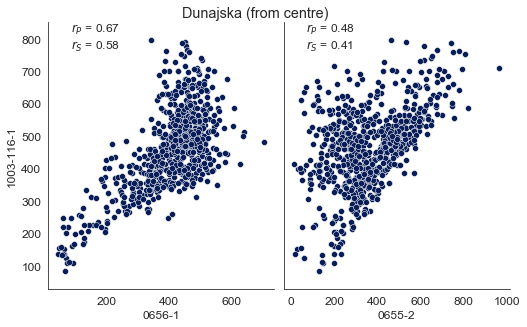

Dunajska (to centre) is in LJ
From 2020-12-16 to 2021-04-30
Measurements: 702


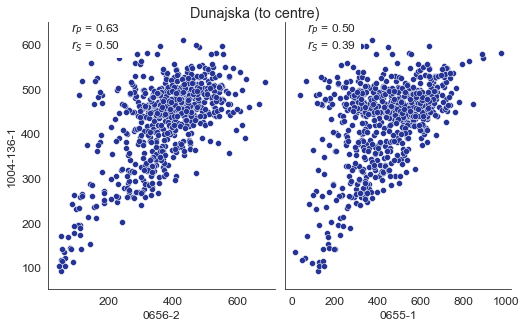

Ižanska (from centre) is in LJ
From 2021-01-29 to 2021-04-30
Measurements: 911


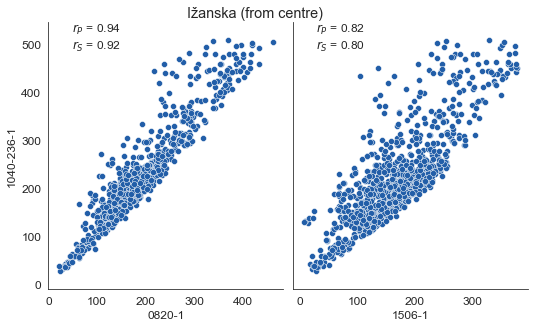

Ižanska (to centre) is in LJ
From 2021-01-29 to 2021-04-30
Measurements: 898


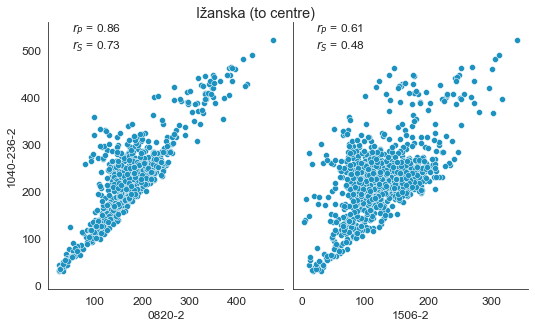

Slovenska (from centre) is in LJ
From 2020-08-25 to 2021-04-30
Measurements: 1673


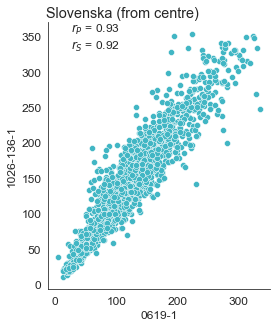

Slovenska (to centre) is in LJ
From 2020-08-25 to 2021-04-30
Measurements: 1692


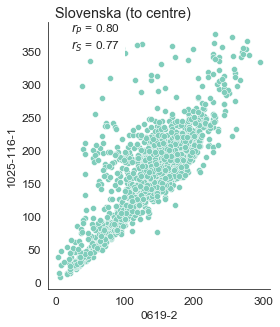

Škofije (towards Koper) is in KP
From 2020-12-03 to 2021-04-30
Measurements: 1383


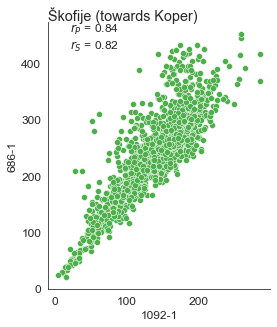

Škofije (towards Trieste) is in KP
From 2020-12-03 to 2021-04-30
Measurements: 1381


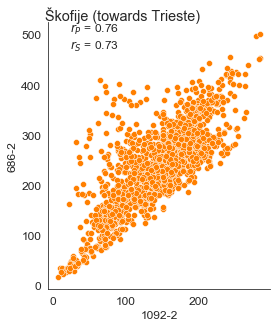

In [32]:
for i, (route_id, counters) in enumerate(route_counters.items()):    
    
    if route_id in routes_in_KP:
        df2 = df_KP.copy()
        print(route_id, "is in KP")
    else:
        df2 = df.copy()
        print(route_id, "is in LJ")
    
    for counter_id in counters:
        if not counter_id:
            continue       
        df3 = df_counters[df_counters["counter_id"]==counter_id][['date', 'time', 'count']].copy()
        df3.columns = ['date', 'time', counter_id]       
        
        df2 = pd.merge(df2, df3, how="left", on=["date", "time"])  
     
    df2.to_csv("data\\route_"+str(route_id)+"_counters.csv", index=False)
    
    # from ... to
    dfx=df2.copy()
    dfx = dfx.dropna(axis='columns', how="all")
    dfx = dfx.dropna(axis="rows")
    print("From", dfx['date'].min(), "to", dfx['date'].max())
    
    # plots
    sns.set_palette([colors[i]])
    
    df2 = df2[counters]
    df2 = df2.dropna(axis='columns', how="all")
    df2 = df2.dropna(axis="rows")
    
    telraam = list(df2.columns[df2.columns.str.startswith("900000")])
    ilc = (set(df2.columns) - set(telraam)).pop()
    
    telraam = [t.replace("900000","") for t in telraam]
    df2.columns = [c.replace("900000","") for c in df2.columns]
    
    print("Measurements:", len(df2))
    
    
    
    g = sns.pairplot(data=df2,  y_vars=ilc, x_vars=telraam)  
    g.map(corrfunc)
    #g.map_lower(corrfunc)
    #g.map_upper(corrfunc)
    g.fig.suptitle(str(route_id), y=1) # y= some height>1
    
    if len(telraam) == 2:
        plt.gcf().set_size_inches(8,5)
    else:
        plt.gcf().set_size_inches(4.5,5)
    
    plt.savefig("figs\\pairplots_counters\\route_"+str(route_id)+"_pairplot.pdf", bbox_inches="tight")
    plt.savefig("figs\\pairplots_counters\\route_"+str(route_id)+"_pairplot.png", bbox_inches="tight")
    plt.savefig("figs\\pairplots_counters\\route_"+str(route_id)+"_pairplot.svg", bbox_inches="tight")
    plt.show()    
        
    

In [55]:
df2

,1003-116-1,0656-1,0655-2
2505,312.0,486.486486,251.194539
2506,363.0,438.923077,395.894428
2507,427.0,482.875918,390.361446
2508,459.0,470.407379,482.993197
2509,492.0,490.524667,428.217636
2510,524.0,413.476263,508.565072
2511,568.0,477.705545,586.585828
2512,630.0,390.189873,685.714286
2529,330.0,431.460674,228.956229
2530,369.0,377.129148,367.624811


In [112]:
"""for i, (route_id, counters) in enumerate(route_counters.items()):    
    
    df2 = df.copy()
    
    for counter_id in counters:
        if not counter_id:
            continue       
        df3 = df_counters[df_counters["counter_id"]==counter_id][['date', 'time', 'count']].copy()
        df3.columns = ['date', 'time', counter_id]       
        
        df2 = pd.merge(df2, df3, how="left", on=["date", "time"])  
        
    df2.to_csv("data\\route_"+str(route_id)+"_counters.csv", index=False)
        
    sns.set_palette([colors[i]])
    
    df2 = df2[counters]
    df2 = df2.dropna(axis='columns', how="all")
    df2 = df2.dropna(axis="rows")
    
    g = sns.pairplot(df2, kind="reg", plot_kws=dict(scatter_kws=dict(s=10)))  
    #g.map(corrfunc)
    g.map_lower(corrfunc)
    g.map_upper(corrfunc)
    g.fig.suptitle("segment: " + str(route_id), y=1) # y= some height>1
    plt.savefig("figs\\pairplots_counters\\route_"+str(route_id)+"_pairplot.pdf", bbox_inches="tight")
    plt.savefig("figs\\pairplots_counters\\route_"+str(route_id)+"_pairplot.png", bbox_inches="tight")
    plt.savefig("figs\\pairplots_counters\\route_"+str(route_id)+"_pairplot.svg", bbox_inches="tight")
    plt.show()    
    """

'for i, (route_id, counters) in enumerate(route_counters.items()):    \n    \n    df2 = df.copy()\n    \n    for counter_id in counters:\n        if not counter_id:\n            continue       \n        df3 = df_counters[df_counters["counter_id"]==counter_id][[\'date\', \'time\', \'count\']].copy()\n        df3.columns = [\'date\', \'time\', counter_id]       \n        \n        df2 = pd.merge(df2, df3, how="left", on=["date", "time"])  \n        \n    df2.to_csv("data\\route_"+str(route_id)+"_counters.csv", index=False)\n        \n    sns.set_palette([colors[i]])\n    \n    df2 = df2[counters]\n    df2 = df2.dropna(axis=\'columns\', how="all")\n    df2 = df2.dropna(axis="rows")\n    \n    g = sns.pairplot(df2, kind="reg", plot_kws=dict(scatter_kws=dict(s=10)))  \n    #g.map(corrfunc)\n    g.map_lower(corrfunc)\n    g.map_upper(corrfunc)\n    g.fig.suptitle("segment: " + str(route_id), y=1) # y= some height>1\n    plt.savefig("figs\\pairplots_counters\\route_"+str(route_id)+"_pairplot.